## RNN Model for Image Classification



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import time
import tqdm

from sklearn.model_selection import KFold


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Constants

In [ ]:
BATCH_SIZE = 64
K_FOLDS = 5
N_X = 28
N_H = 100
LR = 0.001
N_EPOCH = 20

In [ ]:
# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(0.286041, 0.353024)])

### Data Loading: Fashion_Mnist

In [ ]:
# Loading Fashion Mnist dataset from torchVision and downloads it to local machine
train_set = torchvision.datasets.FashionMNIST(root = './data', train = True, download = True, transform = transform)
test_set = torchvision.datasets.FashionMNIST(root = './data', train = False, transform = transform)

# To make sure that we don't run into dimension conflicts, drop the last incomplete batch
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True, num_workers = 2, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 64, shuffle = True, num_workers = 2, drop_last = True)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Construct Models

In [ ]:
# Model for many to one basic RNN with one layer only.
class ImageRNN(nn.Module):
    def __init__(self, n_x, n_h, batch_size):
        super(ImageRNN, self).__init__()
        
        self.n_h = n_h
        self.n_x = n_x

        # batch_size is in x.shape(0), so we set bach_first = True
        self.rnn = nn.RNN(self.n_x, self.n_h, batch_first = True) 
        
        self.outputLayer = nn.Linear(self.n_h, 10)
        
    def forward(self, X):
        
        self.batch_size = X.size(0)
        self.hidden = torch.zeros(1, 64, self.n_h).to(device)
        hidden_set, self.hidden = self.rnn(X, self.hidden)      
        out = self.outputLayer(self.hidden)
        
        return out.view(-1, 10) # batch_size X n_output

    def predict(self, data):
        prediction = 0
        model.eval()
        loader = torch.utils.data.DataLoader(train_set, batch_size = 64, shuffle = True, num_workers = 2, drop_last = True)
        
        for i, (images, labels) in enumerate(loader):
            y = self.forward(images)
            y_category = torch.argmax(y_hat, dim = 1).reshape(-1)
            if i==0:
                prediction = y_category
            else:
                prediction = torch.cat(prediction, y_category)
        
        return prediction
        

In [ ]:
# Model for LSTM.
class LSTM(nn.Module):
    def __init__(self, n_x, n_h, batch_size):
        super(LSTM, self).__init__()
        
        self.n_h = n_h
        self.n_x = n_x
        self.lstm = nn.LSTM(self.n_x, batch_size, batch_first = True) 
        
        self.outputLayer = nn.Linear(batch_size, 10)
        
    def forward(self, X):
        
        output,(h_c,h_x) = self.lstm(X, None) 
        out = self.outputLayer(output[:,-1,:])
        
        return out

### Util functions

In [ ]:
# function that computes the accuracy of a batch
def acc_batch(y_hat, target, batch_size):
    ''' Obtain accuracy for training round '''
    # assign index of the max prediction value as it's class, with axis = 1
    y_category = torch.argmax(y_hat, dim = 1)
    corrects = (y_category == target.data).sum()
    acc= 100.0 * corrects/batch_size
    return acc.item()


def total_acc(loader, model, batch_size):
    with torch.no_grad():
        acc = 0.0
        for j, (x, y) in enumerate(loader):
            x = x.view(-1, 28, 28).to(device)
            y = y.to(device)
            y_hat = model(x)
            acc += acc_batch(y_hat, y, BATCH_SIZE)
        
        return acc/j


def visualize_batch(t):
# Visualize dataset:
# make_grid function takes in tensor of shape (B X C X H X W)
# with B being the batch size and C being the num of channels
# C = 1 since our image is gray scale
# Functions takes a tensor of shape (B X C X H X W) and shows the whole batch of image
    t = torchvision.utils.make_grid(t)

    # permute tensor for plotting
    images_reshaped = t.permute(1,2,0)

    plt.figure(figsize = (7,7))
    plt.imshow(images_reshaped)

In [ ]:
def train_model(model, loss_func, optimizer, n_epoch, train_loader, test_loader):
    train_acc_list = []
    eval_acc_list = []
    for epoch in range(N_EPOCH):  # loop over the dataset multiple times
        train_running_loss = 0.0
        train_acc = 0.0
        model.train()
        
        # Train batches in each epoch
        for i, (images, labels) in enumerate(train_loader):

            # Reset Gradient in every iteration
            optimizer.zero_grad()

            images = images.view(-1, 28,28).to(device)
            labels = labels.to(device)

            # forward and backward propagation
            outputs = model(images)
            # computer loss and gradient
            loss = loss_func(outputs, labels)
            loss.backward()
            # update parameters
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += acc_batch(outputs, labels, BATCH_SIZE)

        model.eval()

        evaluation_acc = total_acc(test_loader, model, BATCH_SIZE)
        train_acc_list.append(train_acc / i)
        eval_acc_list.append(evaluation_acc)

        print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f | Evaluation Accuracy: %.2f' 
            %(epoch, train_running_loss / i, train_acc/i, evaluation_acc))

    return train_acc_list, eval_acc_list   

### Implement K-fold Validation

KFold Cross Validation With RNN

In [ ]:
# Concatenate two datasets
datasetList = [train_set, test_set]
dataset_concated = torch.utils.data.ConcatDataset(datasetList)

# Use KFold in sklearn to distribute data
kfold = KFold(n_splits = K_FOLDS, shuffle = True)
train_acc_list = []
eval_acc_list = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset_concated)):
    print(f'THE {fold}th FOLD')
    print('------------------------------------------------------------------')


    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)


    train_loader = torch.utils.data.DataLoader(dataset_concated, batch_size = BATCH_SIZE, 
                                               sampler = train_subsampler, drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset_concated, batch_size=BATCH_SIZE, 
                                              sampler = test_subsampler, drop_last = True)
    
    # Define model, optimizer and loss function
    model = ImageRNN(N_X, N_H, BATCH_SIZE).to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Training the model and output Accuracy
    trainAcc, evalAcc = train_model(model, loss_func, optimizer, N_EPOCH, train_loader, test_loader)

    # keep track of prediction accuracies
    train_acc_list.append(trainAcc)
    eval_acc_list.append(evalAcc)
    print('\n\n')

THE 0th FOLD
------------------------------------------------------------------
Epoch:  0 | Loss: 0.9196 | Train Accuracy: 65.18 | Evaluation Accuracy: 72.77
Epoch:  1 | Loss: 0.6480 | Train Accuracy: 76.63 | Evaluation Accuracy: 78.67
Epoch:  2 | Loss: 0.5768 | Train Accuracy: 79.61 | Evaluation Accuracy: 77.64
Epoch:  3 | Loss: 0.5421 | Train Accuracy: 80.88 | Evaluation Accuracy: 80.90
Epoch:  4 | Loss: 0.4979 | Train Accuracy: 82.37 | Evaluation Accuracy: 82.42
Epoch:  5 | Loss: 0.4860 | Train Accuracy: 82.79 | Evaluation Accuracy: 80.95
Epoch:  6 | Loss: 0.4717 | Train Accuracy: 83.30 | Evaluation Accuracy: 82.96
Epoch:  7 | Loss: 0.4504 | Train Accuracy: 83.85 | Evaluation Accuracy: 83.58
Epoch:  8 | Loss: 0.4450 | Train Accuracy: 84.08 | Evaluation Accuracy: 83.73
Epoch:  9 | Loss: 0.4400 | Train Accuracy: 84.20 | Evaluation Accuracy: 83.70
Epoch:  10 | Loss: 0.4528 | Train Accuracy: 83.89 | Evaluation Accuracy: 84.63
Epoch:  11 | Loss: 0.4249 | Train Accuracy: 84.77 | Evaluatio

KFolds Cross Validation With LSTM

In [ ]:
# Concatenate two datasets
datasetList = [train_set, test_set]
dataset_concated = torch.utils.data.ConcatDataset(datasetList)

# Use KFold in sklearn to distribute data
kfold = KFold(n_splits = K_FOLDS, shuffle = True)
train_acc_list2 = []
eval_acc_list2 = []

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset_concated)):
    print(f'THE {fold}th FOLD')
    print('------------------------------------------------------------------')


    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)


    train_loader = torch.utils.data.DataLoader(dataset_concated, batch_size = BATCH_SIZE, 
                                               sampler = train_subsampler, drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset_concated, batch_size=BATCH_SIZE, 
                                              sampler = test_subsampler, drop_last = True)
    
    # Define model, optimizer and loss function
    model = LSTM(N_X, N_H, BATCH_SIZE).to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Training the model and output Accuracy
    trainAcc, evalAcc = train_model(model, loss_func, optimizer, N_EPOCH, train_loader, test_loader)

    # keep track of prediction accuracies
    train_acc_list2.append(trainAcc)
    eval_acc_list2.append(evalAcc)
    print('\n\n')

THE 0th FOLD
------------------------------------------------------------------
Epoch:  0 | Loss: 0.7189 | Train Accuracy: 74.12 | Evaluation Accuracy: 82.45
Epoch:  1 | Loss: 0.4377 | Train Accuracy: 84.31 | Evaluation Accuracy: 85.65
Epoch:  2 | Loss: 0.3856 | Train Accuracy: 86.23 | Evaluation Accuracy: 86.58
Epoch:  3 | Loss: 0.3556 | Train Accuracy: 87.26 | Evaluation Accuracy: 86.76
Epoch:  4 | Loss: 0.3347 | Train Accuracy: 87.86 | Evaluation Accuracy: 87.51
Epoch:  5 | Loss: 0.3203 | Train Accuracy: 88.47 | Evaluation Accuracy: 88.08
Epoch:  6 | Loss: 0.3057 | Train Accuracy: 88.99 | Evaluation Accuracy: 88.52
Epoch:  7 | Loss: 0.2941 | Train Accuracy: 89.43 | Evaluation Accuracy: 88.63
Epoch:  8 | Loss: 0.2856 | Train Accuracy: 89.75 | Evaluation Accuracy: 88.70
Epoch:  9 | Loss: 0.2778 | Train Accuracy: 89.95 | Evaluation Accuracy: 89.20
Epoch:  10 | Loss: 0.2688 | Train Accuracy: 90.19 | Evaluation Accuracy: 89.45
Epoch:  11 | Loss: 0.2626 | Train Accuracy: 90.50 | Evaluatio

In [ ]:
import pickle

# Save result
with open('train_acc_list.pkl', 'wb') as f:
    pickle.dump(train_acc_list, f)

with open('eval_acc_list.pkl', 'wb') as f:
    pickle.dump(train_acc_list, f)

In [ ]:
#save the LSTM model using pikle 
filename = 'LSTM_model.sav'
with open('LSTM_model.sav', 'wb') as f:
    pickle.dump(model,f)


In [ ]:
torch.cuda.get_device_name(0)

range(1, 21)


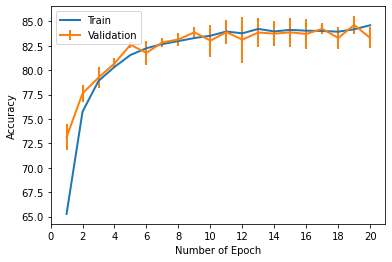

In [ ]:
eval_acc_list = np.array(eval_acc_list)
train_acc_list = np.array(train_acc_list)


eval_mean = np.mean(eval_acc_list, axis = 0)
eval_std = np.std(eval_acc_list, axis = 0)
train_mean = np.mean(train_acc_list, axis = 0)
train_std = np.std(train_acc_list, axis = 0)

k_list = range(1,21)
print(k_list)

plt.plot(k_list, train_mean, label='Rnn_Train', linewidth = 2)
plt.errorbar(k_list, eval_mean, eval_std, label='Validation', linewidth = 2)

plt.xticks(range(0,22, 2))
plt.legend()
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')

plt.savefig('Epoch_Accuracy_Chart.jpg', format = 'JPEG')

range(1, 21)


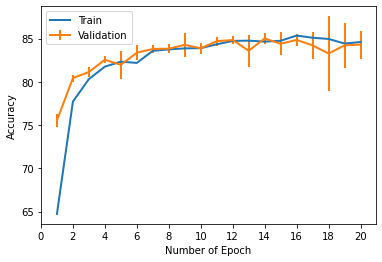

In [ ]:
eval_acc_list = np.array(eval_acc_list)
train_acc_list = np.array(train_acc_list)


eval_mean = np.mean(eval_acc_list, axis = 0)
eval_std = np.std(eval_acc_list, axis = 0)
train_mean = np.mean(train_acc_list, axis = 0)
train_std = np.std(train_acc_list, axis = 0)

k_list = range(1,21)
print(k_list)

plt.plot(k_list, train_mean, label='Train', linewidth = 2)
plt.errorbar(k_list, eval_mean, eval_std, label='Validation', linewidth = 2)
plt.xticks(range(0,22, 2))
plt.legend()
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')

plt.savefig('Epoch_Accuracy_Chart.jpg', format = 'JPEG')

range(1, 21)


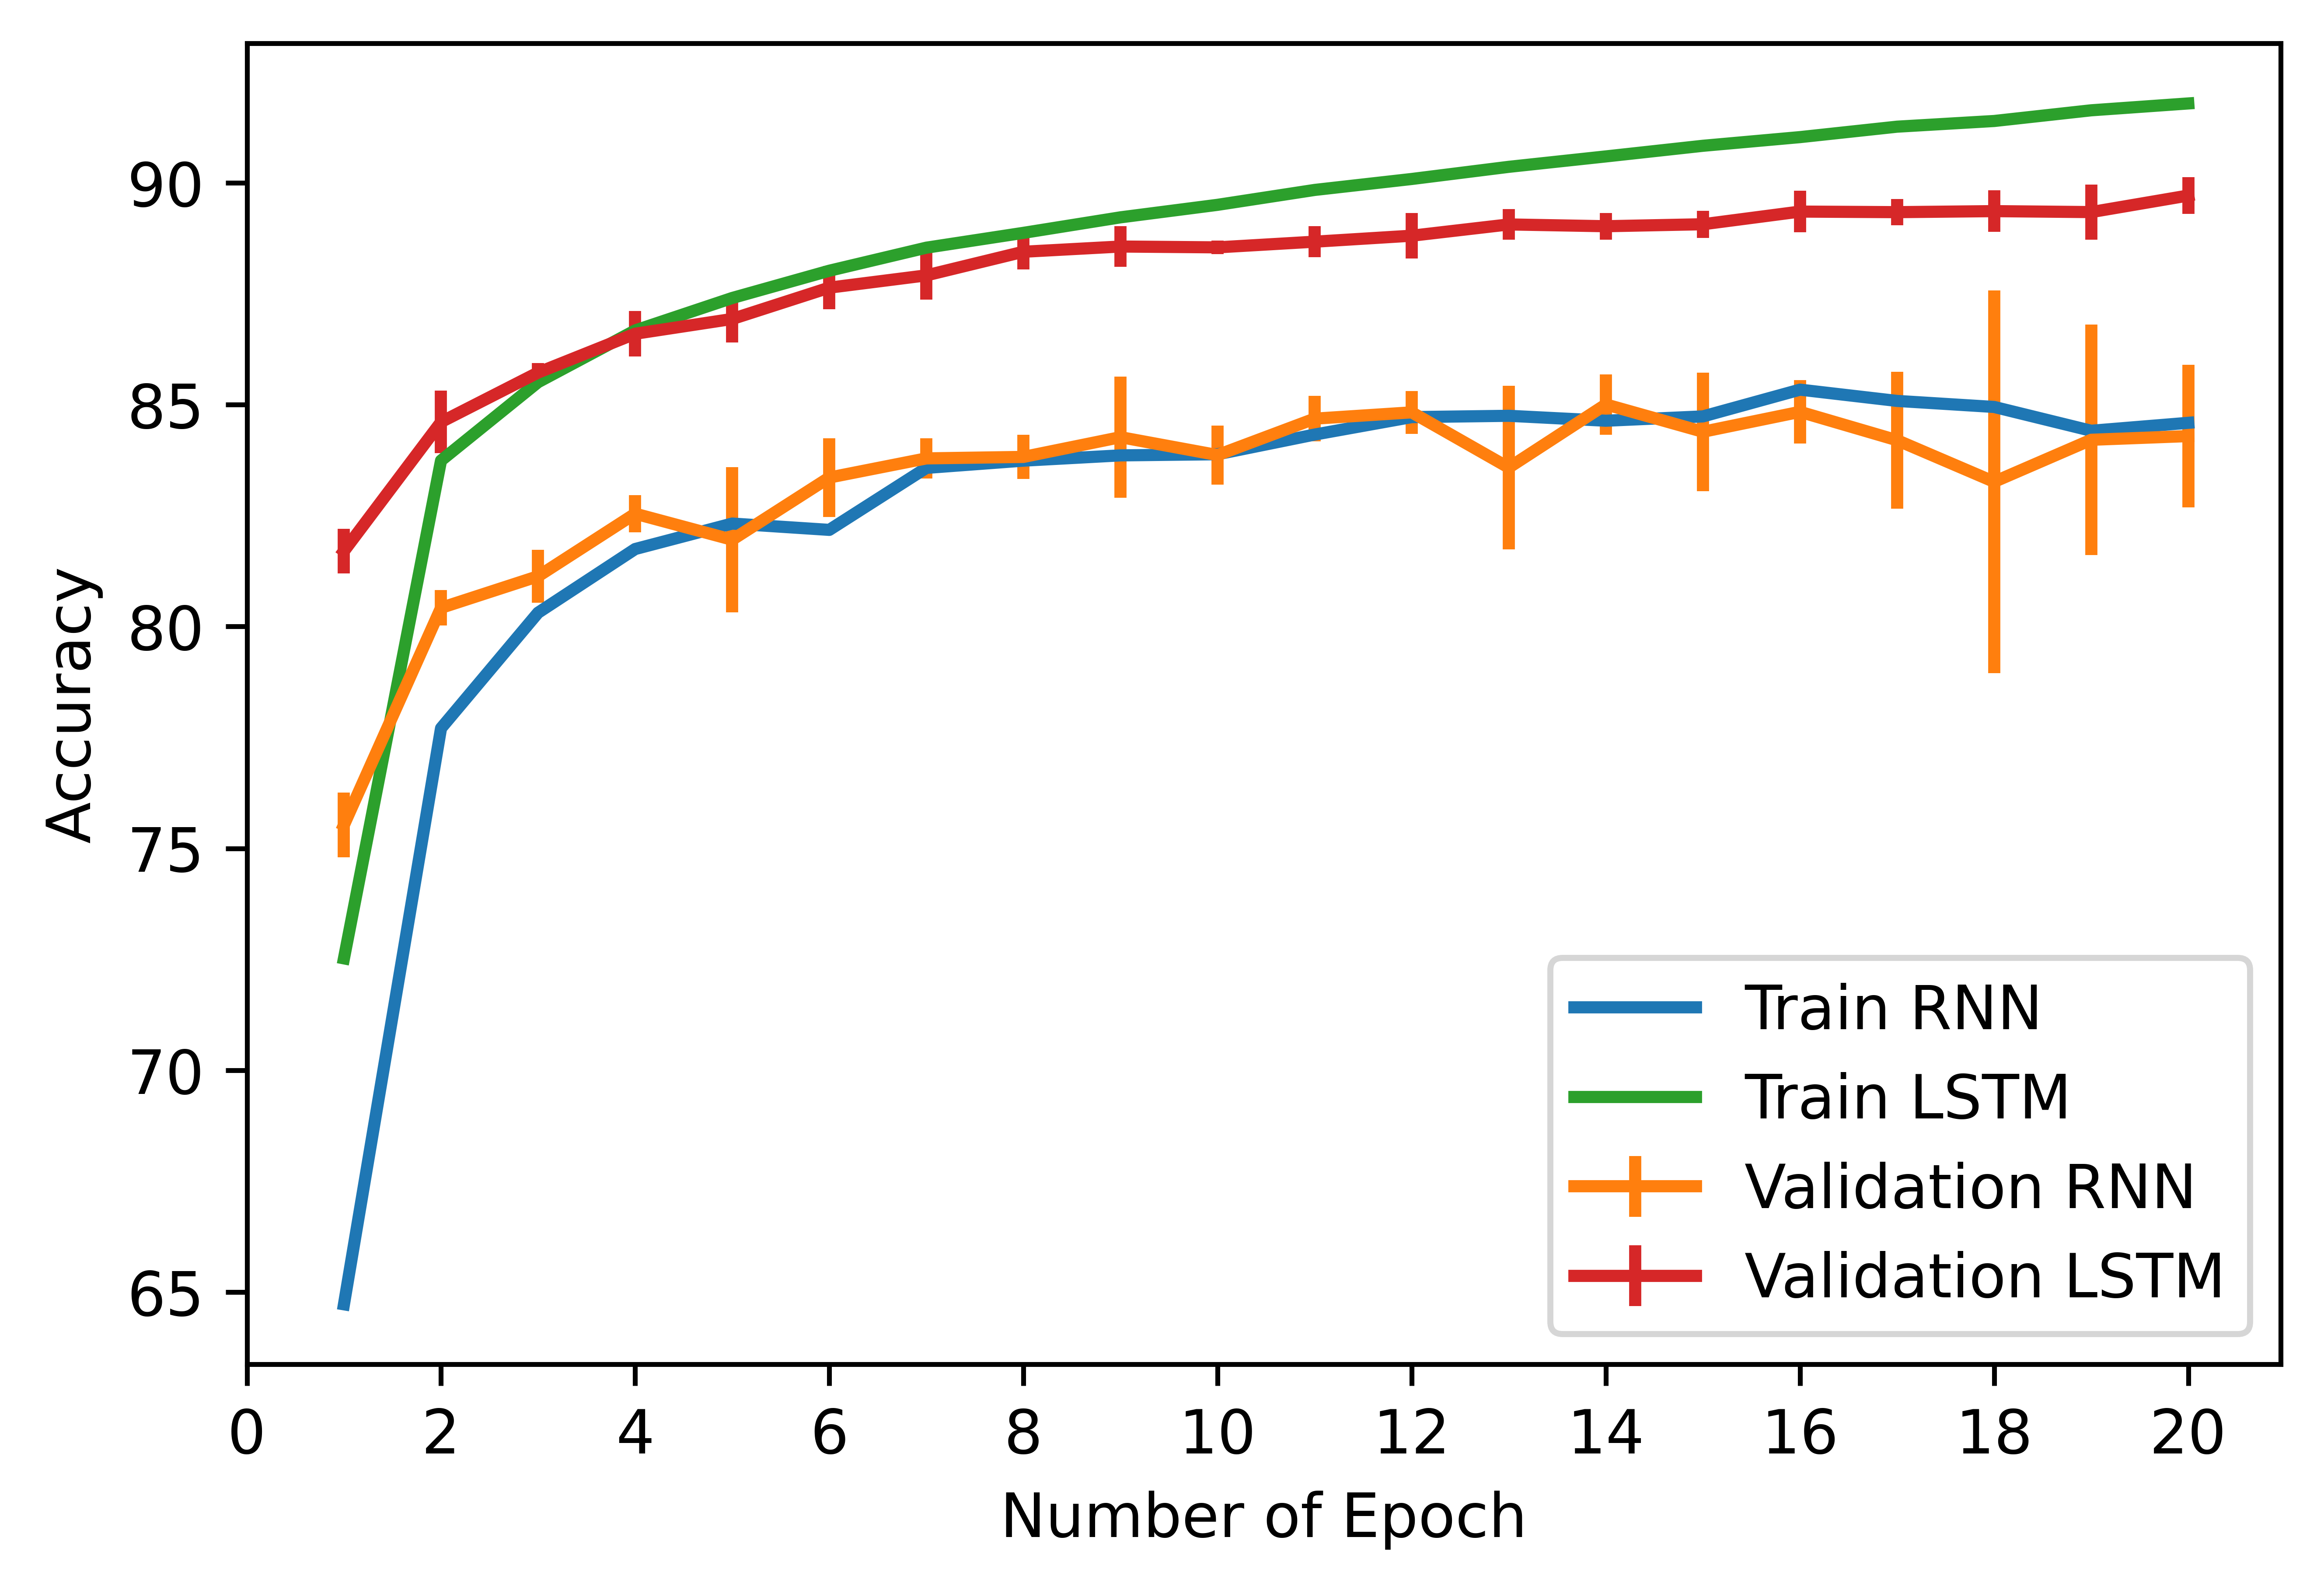

In [ ]:
eval_acc_list = np.array(eval_acc_list)
train_acc_list = np.array(train_acc_list)
eval_acc_list2 = np.array(eval_acc_list2)
train_acc_list2 = np.array(train_acc_list2)
val_acc_list = np.array(eval_acc_list)
train_acc_list = np.array(train_acc_list)


eval_mean = np.mean(eval_acc_list, axis = 0)
eval_std = np.std(eval_acc_list, axis = 0)
train_mean = np.mean(train_acc_list, axis = 0)
train_std = np.std(train_acc_list, axis = 0)
val_acc_list2 = np.array(eval_acc_list2)
train_acc_list2 = np.array(train_acc_list2)


eval_mean2 = np.mean(eval_acc_list2, axis = 0)
eval_std2 = np.std(eval_acc_list2, axis = 0)
train_mean2 = np.mean(train_acc_list2, axis = 0)
train_std2 = np.std(train_acc_list2, axis = 0)

k_list = range(1,21)
print(k_list)
plt.figure(dpi=1000)
plt.plot(k_list, train_mean, label='Train RNN', linewidth = 2)
plt.errorbar(k_list, eval_mean, eval_std, label='Validation RNN', linewidth = 2)
plt.xticks(range(0,22, 2))
plt.legend()

plt.plot(k_list, train_mean2, label='Train LSTM', linewidth = 2)
plt.errorbar(k_list, eval_mean2, eval_std2, label='Validation LSTM', linewidth = 2)
plt.xticks(range(0,22, 2))
plt.legend()

plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.savefig('Epoch_Accuracy_Chart_RNN_VS_LSTM.jpg', format = 'JPEG', dpi = 500)





'/content'

In [ ]:
from configs import *
print(PLOT_DIR)

/home/tai/XDF_Project/MIT-Reserach/Homework2/plots/
